# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [2]:
# imports
import numpy as np;

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

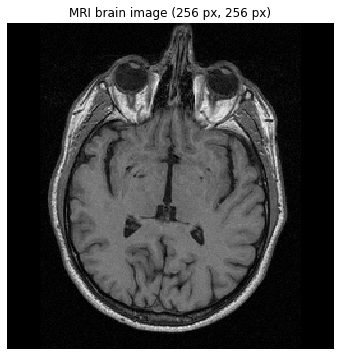

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

In [4]:
import cv2
import numpy as np

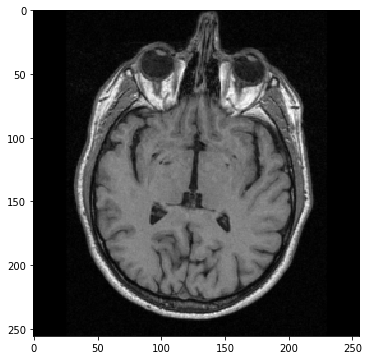

In [5]:
# Using Gaussian filter to denoise image
brain_denoise = cv2.GaussianBlur(brain_im,(5,5),0.5,0.5)
plt.figure(figsize=[6,6])
plt.imshow(brain_denoise,cmap='gray')

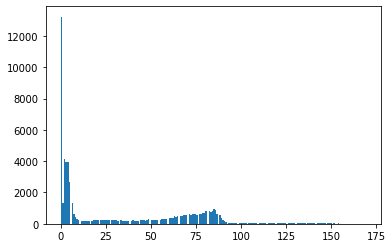

In [6]:
plt.hist(brain_denoise.ravel(),bins=200)
plt.show()

In [7]:
def region_growing(img, seed, threshold):

    img = np.float32(img)
    
    # 8-connected growing method
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1),(-1,-1),(-1,1),(1,1),(1,-1)]
    region_size = 1
    neighbor_points_list = []
    neighbor_points_list.append(seed)
    
    #Initialize segmented output image
    height,width = img.shape
    segmented_img = np.zeros((height, width), np.uint8)
    
    while len(neighbor_points_list) != 0:  
        
        seed = neighbor_points_list.pop(0)
        for i in range(8):
            
            #Compute the neighbor pixel position
            x_new = seed[0] + neighbors[i][0]
            y_new = seed[1] + neighbors[i][1]
            
            checkout = (x_new >= 0) & (y_new >= 0) & (x_new < height) & (y_new < width)
            if checkout:
                if segmented_img[x_new, y_new] == 0:
                    
                    # compute difference
                    difference = np.abs(img[x_new,y_new]-img[seed[0],seed[1]])
                    
                    if difference <= threshold:
                        
                        neighbor_points_list.append([x_new,y_new])
                        segmented_img[x_new, y_new] = 255
                        region_size+=1
                        
    return segmented_img,region_size

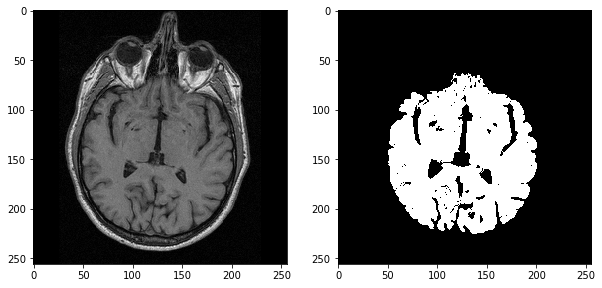

In [8]:
# set seed
seed = [153,82]
segmented_img, region_size = region_growing(brain_denoise, seed, 4)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(brain_im, cmap='gray')
ax[1].imshow(segmented_img,cmap='gray')
plt.show()

In [9]:
print("The brain size is ",region_size)

The brain size is  16117


In [10]:
# try to combine the two thresholding parameters to get better result

##### 1.3 Contour detection
Add your implementation and discussion

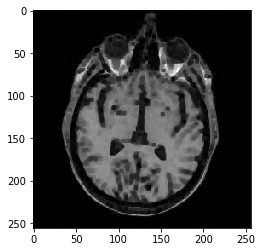

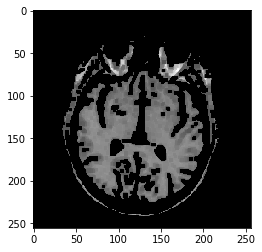

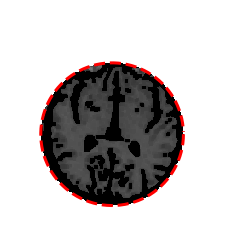

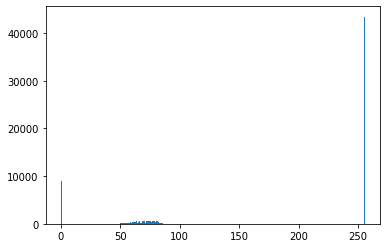

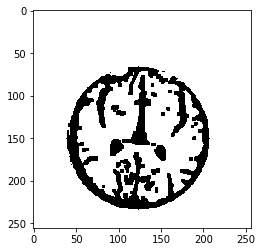

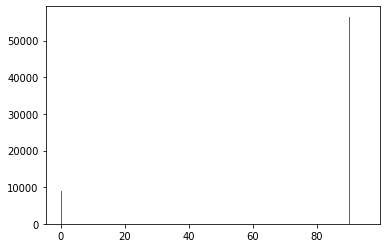

In [11]:
from scipy.ndimage import grey_erosion, grey_dilation
brain_processing = grey_erosion(brain_im, size = (4,4))
plt.imshow(brain_processing,'gray')
plt.show()

# remove dark gray and black by thresholding
brain_processing[brain_processing<50] = 0 # reduce noise

plt.imshow(brain_processing,'gray')
plt.show()

# detect circle brain --> background white
def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T
# Exclude last point because a closed path should not have duplicate points
xc = 123
yc = 150
radius = 84
points = circle_points(200, [150, 123], 84)[:-1]

def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4, 4))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

fig, ax = image_show(brain_processing)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

for y in range(brain_processing.shape[0]):
    for x in range(brain_processing.shape[1]):
        if ((x - xc) ** 2 + (y - yc) ** 2) > radius ** 2:
            brain_processing[y][x] = 255;
    
plt.imshow(brain_processing,'gray')
plt.show()

plt.hist(brain_processing.ravel(), 256,[0,256]);
plt.show()


# from the histogram we can see that we have a lot of values at 0, 255 and between 30 to 100 --> we want to have just 2 values (0 and 90)
brain_processing[brain_processing > 30] = 90

brain_processing = grey_dilation(brain_processing, size = (1,1))

plt.imshow(brain_processing,'gray')
plt.show()

# plt.hist(brain_processing.ravel(), 256,[0,256]); #double check we have no values at 255

plt.hist(brain_processing.ravel(), 256,[0,95]);

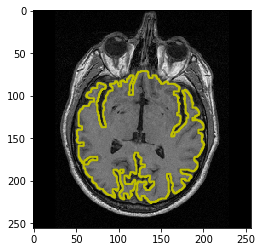

In [12]:
from skimage import measure
from cv2 import fillPoly
# find constant valued contours in an image. Array values are linearly interpolated to provide 
# better precision of the output contours.
# contours at constant value 0.8
contours = measure.find_contours(brain_processing, 0.8)

# https://stackoverflow.com/questions/39642680/create-mask-from-skimage-contour
# Select the largest contiguous contour
contour = sorted(contours, key=lambda x: len(x))[-1]

# Display the image and plot the contour
fig, ax = plt.subplots()
ax.imshow(brain_im, interpolation='nearest', cmap=plt.cm.gray)
X, Y = ax.get_xlim(), ax.get_ylim()
ax.step(contour.T[1], contour.T[0], linewidth=2, c='y')
ax.set_xlim(X), ax.set_ylim(Y)
plt.show()


Brain area is:  16028


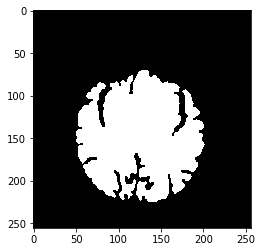

In [13]:
# compute area inside (https://stackoverflow.com/questions/39642680/create-mask-from-skimage-contour)
import scipy.ndimage as ndimage    

# Create an empty image to store the masked array
r_mask = np.zeros_like(brain_im, dtype='bool')

# Create a contour image by using the contour coordinates rounded to their nearest integer value
r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1

# Fill in the hole created by the contour boundary
r_mask = ndimage.binary_fill_holes(r_mask)

# Invert the mask since you want pixels outside of the region
# r_mask = ~r_mask
plt.imshow(r_mask, cmap=plt.cm.gray)

area_brain_tot = np.sum(r_mask) # tot True in mask

print("Brain area is: ", area_brain_tot)

Brain area is:  16482.5


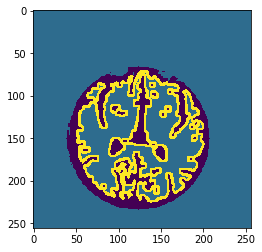

In [14]:
# Find the contour of the brain with opencv (https://towardsdatascience.com/computer-vision-for-beginners-part-4-64a8d9856208)
img = brain_processing.copy()
contours, hierarchy = cv2.findContours(
                                   image = img, 
                                   mode = cv2.RETR_TREE, 
                                   method = cv2.CHAIN_APPROX_SIMPLE)

# Sort the contours 
contours = sorted(contours, key = cv2.contourArea, reverse = True)
# print(len(contours)) # 29
contours = contours[2:22];
# we are interested to contours[2] (brain), details of brain: contours[3], contours[4], contours[5], contours[6], ... contours[20] --> just select brain

# Draw the contour 
img_copy = img.copy()
final = cv2.drawContours(img_copy, contours, contourIdx = -1, 
                         color = (255, 0, 0), thickness = 2)
plt.imshow(img_copy)

# The area of contours 
area_brain_tot = 0;
for i in range(len(contours)):
    area_brain_tot = area_brain_tot + cv2.contourArea(contours[i])
    
print("Brain area is: ", area_brain_tot)

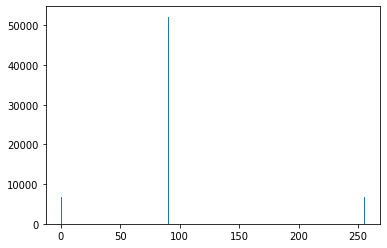

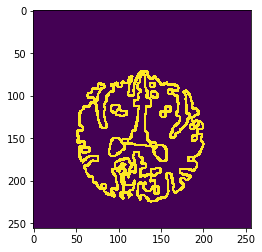

In [15]:
# remove part outside brain (just graphically)
plt.hist(img_copy.ravel(), 256,[0,256]);
plt.show()

img_copy[img_copy < 150] = 0;

plt.imshow(img_copy)


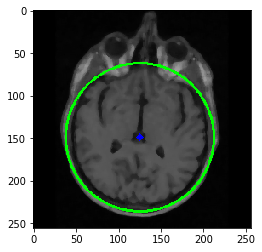

In [16]:
# Brain detection by edge using canny
# use Hough Transform to find circles in an image --> our bain
img = cv2.medianBlur(brain_im.copy(),5)
cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) #convert to grayscale

# dp – Inverse ratio of the accumulator resolution to the image resolution. 
# minDist – Minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed.
# param1: it is the higher threshold of the two passed to the Canny() edge detector. (same as threshold of canny)
# param2: it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, dp=4.9, minDist=300,
                            param1=90, param2=55 ,minRadius=0 ,maxRadius=0)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plt.imshow(cimg, cmap='gray')
plt.show()

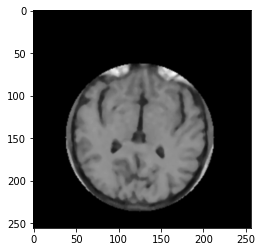

In [17]:
from math import hypot

# Create a mask (https://stackoverflow.com/questions/34290781/how-to-mask-circular-area)
circles = np.uint16(np.around(circles))

x, y, r = circles[0,:][0]
rows, cols = img.shape

for i in range(cols):
    for j in range(rows):
        if hypot(i-x, j-y) > r:
            img[j,i] = 0

plt.imshow(img, cmap='gray', interpolation = 'bicubic')
plt.show()

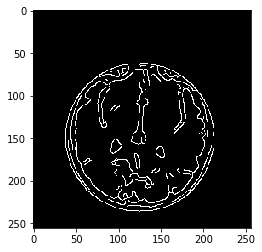

In [18]:
from skimage import feature

edges_mask = skimage.feature.canny(
    image=img,
    sigma=.8,
    low_threshold=30,
    high_threshold=50,
)

# display edges
plt.imshow(edges_mask, cmap='gray')
plt.show()

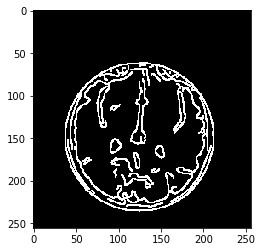

In [19]:
# dilation
kernel_22 = np.ones((2,2), np.uint8)
brain_mask_dilation = ndimage.binary_dilation(edges_mask, kernel_22, iterations=1) 
plt.imshow(brain_mask_dilation, cmap='gray')

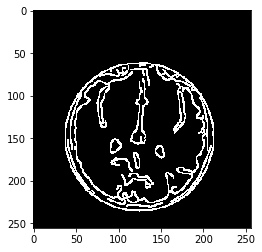

In [20]:
from scipy import ndimage as ndi
from skimage import morphology

remove_small_objs_brain = morphology.remove_small_objects(brain_mask_dilation.astype(bool), min_size=90)

# remove_small_objs_brain = 1 - remove_small_objs_brain
plt.imshow(remove_small_objs_brain, cmap='gray')

The number of pixels counted as the brain are 5773.


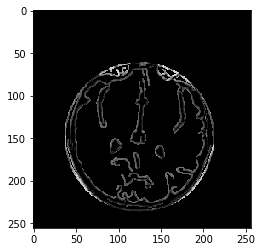

In [21]:
print('The number of pixels counted as the brain are {}.'.format(np.sum(remove_small_objs_brain)))
overlap_brain = brain_im & (remove_small_objs_brain*255)
plt.imshow(overlap_brain, cmap='gray')

# plt.hist(compare_images.ravel(), 256,[0,256]);
# plt.show()

# Threshold
# def threshold(t1, t2, img):

In [22]:
# Threshold
def threshold(t1, t2, img):
    th_img = img.copy()
    th_img[th_img < t1] = 0
    th_img[th_img > t2] = 0
    th_img[(th_img >= t1) & (th_img <= t2)] = 1
    return th_img

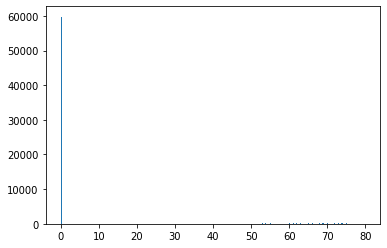

In [23]:
plt.hist(overlap_brain.ravel(), 256,[0,80]);
brain_diff_threshold = threshold(10, 100, overlap_brain)

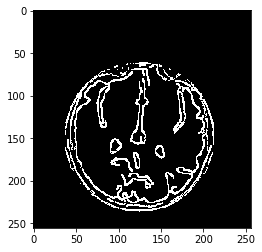

In [24]:
plt.imshow(brain_diff_threshold, cmap='gray')

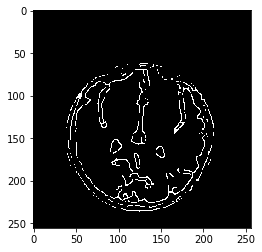

In [25]:
brain_processing = brain_diff_threshold.copy()

kernel_44 = np.ones((2,2), np.uint8) 
kernel2 = np.ones((2,1), np.uint8) 
kernel3 = np.ones((2,2), np.uint8) 


# The first parameter is the original image, 
# kernel is the matrix with which image is  
# convolved and third parameter is the number  
# of iterations, which will determine how much  
# you want to erode/dilate a given image.  
# img_erosion = cv2.erode(i_thresholded, kernel, iterations=1) 
# img_dilation = cv2.dilate(img_erosion, kernel, iterations=1) 

from scipy import ndimage
brain_processing = ndimage.binary_opening(brain_processing, kernel_22, iterations=1) 
brain_processing = ndimage.binary_erosion(brain_processing, kernel_22, iterations=1)
brain_processing = ndimage.binary_closing(brain_processing, kernel_22, iterations=1) 



plt.imshow(brain_processing, cmap='gray')

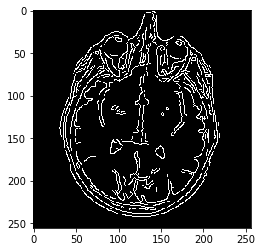

In [26]:
# Canny algorithm
# 1) Nois reduction
# 2) Gradient calculation
# 3) Non-maximum suppression
# 4) Double threshold
# 5) Edge Tracking by Hysteresis

from skimage import feature

edges = skimage.feature.canny(
    image=brain_im,
    sigma=.8,
    low_threshold=55,
    high_threshold=90,
)

# display edges
plt.imshow(edges, cmap='gray')
plt.show()

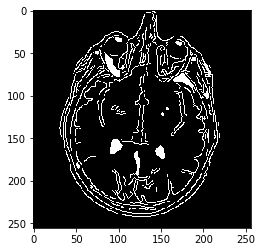

In [27]:
from scipy import ndimage as ndi
fill_brain = ndi.binary_fill_holes(edges)

plt.imshow(fill_brain, cmap='gray')
plt.show()

### 1.4 Additional method(s)
Add your implementation and discussion

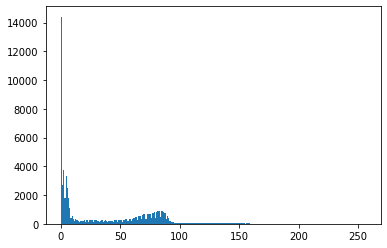

In [28]:
# Histogram
plt.hist(brain_im.ravel(), 256,[0,256]);
plt.show()

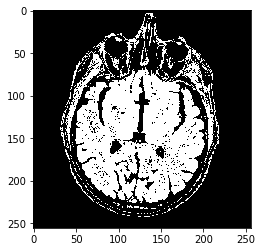

In [29]:
# apply threshold
th_img_wdg = threshold(55, 90, brain_im)
plt.imshow(th_img_wdg, cmap='gray')
plt.show()

# Adaptive thresholding does not make sense since we will have the same intensities in all the image (e.g. no more exposition in a part of the image)

## Thresholding, morphological operators, labeling

In [30]:
# initial threshold
i_thresholded = threshold(55, 100, i)
# morphological operator kernel
kernel = np.ones((3,3), np.uint8) 
# erosion to separate brain from skull
img_erosion = ndimage.binary_erosion(i_thresholded, kernel, iterations=1) 
plt.figure()
plt.imshow(i_thresholded, cmap='gray')



AttributeError: 'int' object has no attribute 'copy'

In [ ]:
from scipy.stats import mode
# label features
labeled_array, num_features = ndi.label(img_erosion)
# find brain region = largest connected components
brain_region_label,_ = mode(labeled_array[labeled_array!=0])
# isolate brain region
brain_region = np.where(labeled_array != brain_region_label.item(), 0, img_erosion)
# dilation to restore pixels lost in erosion
brain_region_restored = ndimage.binary_dilation(brain_region, kernel3, iterations=1) 
plt.imshow(brain_region_restored, cmap='gray')

In [ ]:
print("brain area is: ", np.sum(brain_region_restored))

## Thresholding, morphological operators, labeling 2 (based on Somasundaram et al.)

In [ ]:
from skimage import feature
from skimage.morphology import disk
from skimage.filters import rank

brain_denoise = cv2.GaussianBlur(brain_im,(5,5),.5,.5)

# blur the image with circular element
selem = disk(40)
brain_blur = rank.mean(brain_im, selem=selem)

# find a rough mask of the brain with thresholding
i_thresholded = threshold(45, 95, brain_blur)
plt.imshow(brain_denoise*i_thresholded, cmap='gray')



In [ ]:
# Gray level erosion with structuring element of level 99 (empirical)
from scipy import ndimage
kernel = np.ones((11,11), np.uint8)*99
rough_mask = brain_denoise*i_thresholded
img_erosion = ndimage.grey_erosion(rough_mask,structure=kernel)

plt.imshow(img_erosion, cmap = 'gray')

In [ ]:
# thresholding to extract the brain tissue and use binary erosion to separate the brain tissue from other unwanted pixels
i_thresholded = threshold(210, 255, img_erosion.astype(np.float))
kernel2 = np.ones((3,1), np.uint8)
# plt.imshow(i_thresholded, cmap='gray')
img_erosion2 = ndimage.binary_erosion(i_thresholded, kernel2, iterations=1).astype(i_thresholded.dtype) 
plt.imshow(img_erosion2, cmap='gray')

In [ ]:
from scipy.stats import mode
#
labeled_array, num_features = ndi.label(img_erosion2)
brain_region_label,_ = mode(labeled_array[labeled_array!=0])
brain_region = np.where(labeled_array != brain_region_label.item(), 0, img_erosion2)
brain_region_restored= ndimage.binary_dilation(brain_region, kernel2, iterations=1) 
plt.imshow(brain_region_restored,cmap='gray')
brain_region_label
print("brain area is: ", np.sum(brain_region_restored))

In [ ]:
import cv2
i = brain_im.copy()
mask = cv2.Canny(i, 55, 90)
cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for c in cnts[0]:
    c = cv2.convexHull(c)
    
for c in cnts[0]:
    cv2.drawContours(i, c, -1, (0, 230, 255), 2)
    
plt.figure()
plt.imshow(i, cmap='gray')

In [ ]:
plt.hist(i.ravel(), 256,[0,256])
plt.show()

In [ ]:
# copy the function threshold above it (you find it below)
i_thresholded = threshold(65, 95, i)
plt.figure()
plt.imshow(i_thresholded, cmap='gray')

In [ ]:
kernel1 = np.ones((2,2), np.uint8) 
kernel2 = np.ones((2,1), np.uint8) 
kernel3 = np.ones((2,2), np.uint8) 


# The first parameter is the original image, 
# kernel is the matrix with which image is  
# convolved and third parameter is the number  
# of iterations, which will determine how much  
# you want to erode/dilate a given image.  
# img_erosion = cv2.erode(i_thresholded, kernel, iterations=1) 
# img_dilation = cv2.dilate(img_erosion, kernel, iterations=1) 

from scipy import ndimage
img_closing = ndimage.binary_closing(i_thresholded, kernel1, iterations=3) 
img_opening = ndimage.binary_opening(img_closing, kernel3, iterations=1) 
img_erosion = ndimage.binary_erosion(img_opening, kernel2, iterations=1) 
    
plt.figure()
plt.imshow(img_erosion, cmap='gray')

In [ ]:
type(img_closing)

In [ ]:
# Active countours to detect external part of brain, threshold, then segment
# Active Contour segmentation (snakes)
# snake does not work
#rewrite code

def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax
# fig, ax = image_show(brain_denoise)


def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T
# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [153, 123], 70)[:-1]
# ax.plot(points[:, 0], points[:, 1], '--r', lw=3)


In [ ]:
import skimage.segmentation as seg
# snake = skimage.segmentation.active_contour(brain_denoise, points, alpha=0.002, beta=1, gamma=0.001)
snake = seg.active_contour(edges, points, alpha=0.015, beta=10, gamma=0.001)

fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

# todo detect params alpha, beta, gamma

In [ ]:
# Random walker


## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [ ]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

In [ ]:
# https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html --> look it! 
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches

# from skimage import data
# from skimage.filters import threshold_otsu
# from skimage.segmentation import clear_border
# from skimage.measure import label, regionprops
# from skimage.morphology import closing, square
# from skimage.color import label2rgb


# image = data.coins()[50:-50, 50:-50]

# # apply threshold
# thresh = threshold_otsu(image)
# bw = closing(image > thresh, square(3))

# # remove artifacts connected to image border
# cleared = clear_border(bw)

# # label image regions
# label_image = label(cleared)
# image_label_overlay = label2rgb(label_image, image=image)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow(image_label_overlay)

# for region in regionprops(label_image):
#     # take regions with large enough areas
#     if region.area >= 100:
#         # draw rectangle around segmented coins
#         minr, minc, maxr, maxc = region.bbox
#         rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
#                                   fill=False, edgecolor='red', linewidth=2)
#         ax.add_patch(rect)

# ax.set_axis_off()
# plt.tight_layout()
# plt.show()

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion